In [3]:
import seaborn as sb
import matplotlib.pyplot as pl
import numpy as np
import pymc3 as pm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

We are going to create eight related data groups, including one with just one data point:

In [19]:
idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 7])

In [11]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(60, 10, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

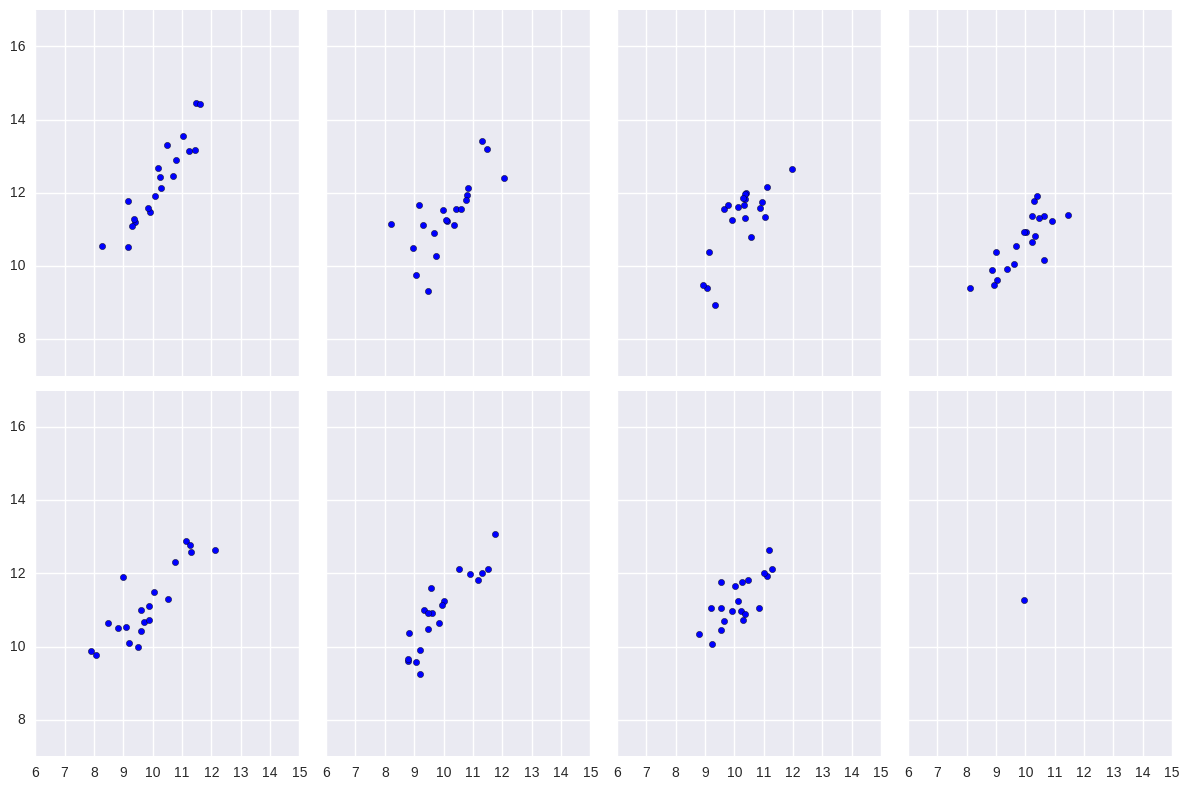

In [14]:
f,axs = pl.subplots(nrows=2, ncols=4, figsize=(12,8),sharex=True, sharey=True)
j, k = 0, N
for i,ax in zip(range(M), axs.ravel()):
    #pl.subplot(2,4, i+1)
    ax.scatter(x_m[j:k], y_m[j:k])
    ax.set_xlim(6, 15)
    ax.set_ylim(7, 17)
    j += N
    k += N
f.tight_layout()

 Center the data before feeding it to the model. But inside the code  we are going to include code to re-scale alpha to the original scale

In [15]:
x_centered = x_m - x_m.mean()

In [16]:
with pm.Model() as unpooled_model:
    alpha_tmp = pm. Normal('alpha_tmp', mu=0, sd=10, shape=M)
    beta = pm.Normal('beta', mu=0, sd=10, shape=M)
    epsilon=pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)
    y_pred = pm.StudentT('y_pred', 
                         mu=alpha_tmp[idx]+beta[idx]*x_centered,
                        sd=epsilon, nu=nu, observed=y_m)
    alpha = pm.Deterministic('alpha', alpha_tmp - beta*x_m.mean())
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_up = pm.sample(2000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 167.160737
         Iterations: 38
         Function evaluations: 52
         Gradient evaluations: 52


100%|██████████| 2000/2000 [00:12<00:00, 153.87it/s]


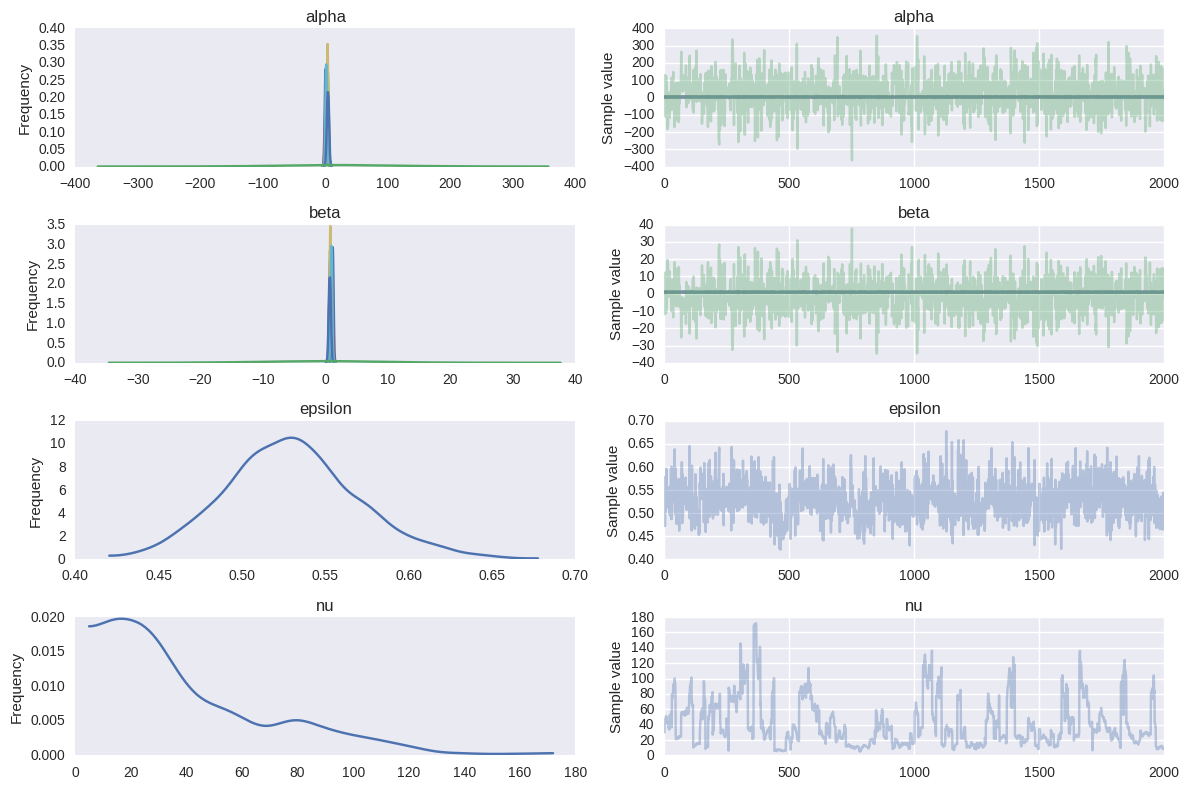

In [18]:
varnames=['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(trace_up, varnames);

In [26]:
with pm.Model() as hierarchical_model:
    alpha_tmp_mu = pm.Normal('alpha_tmp_mu', mu=0, sd=10)
    alpha_tmp_sd = pm.HalfNormal('alpha_tmp_sd', 10)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=10)
    beta_sd = pm.HalfNormal('beta_sd', sd=10)
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_tmp_mu, sd=alpha_tmp_sd, shape=M)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)
    y_pred = pm.StudentT('y_pred', mu=alpha_tmp[idx]+beta[idx]*x_centered,
                        sd=epsilon, nu=nu, observed=y_m)
    alpha = pm.Deterministic('alpha', alpha_tmp-beta*x_m.mean())
    alpha_mu = pm.Deterministic('alpha_mu', alpha_tmp_mu - beta_mu * x_m.mean())
    alpha_sd = pm.Deterministic('alpha_sd', alpha_tmp_sd - beta_mu * x_m.mean())
    
    mu, sds, elbo = pm.variational.advi(n=100000)
    cov_scal = np.power(hierarchical_model.dict_to_array(sds), 2)
    step = pm.NUTS(scaling=cov_scal, is_cov=True)
    trace_hm = pm.sample(1000, step=step, start=mu)

Average ELBO = -147.9: 100%|██████████| 100000/100000 [00:21<00:00, 4623.37it/s]
Finished [100%]: Average ELBO = -147.89
100%|██████████| 1000/1000 [00:15<00:00, 66.19it/s]


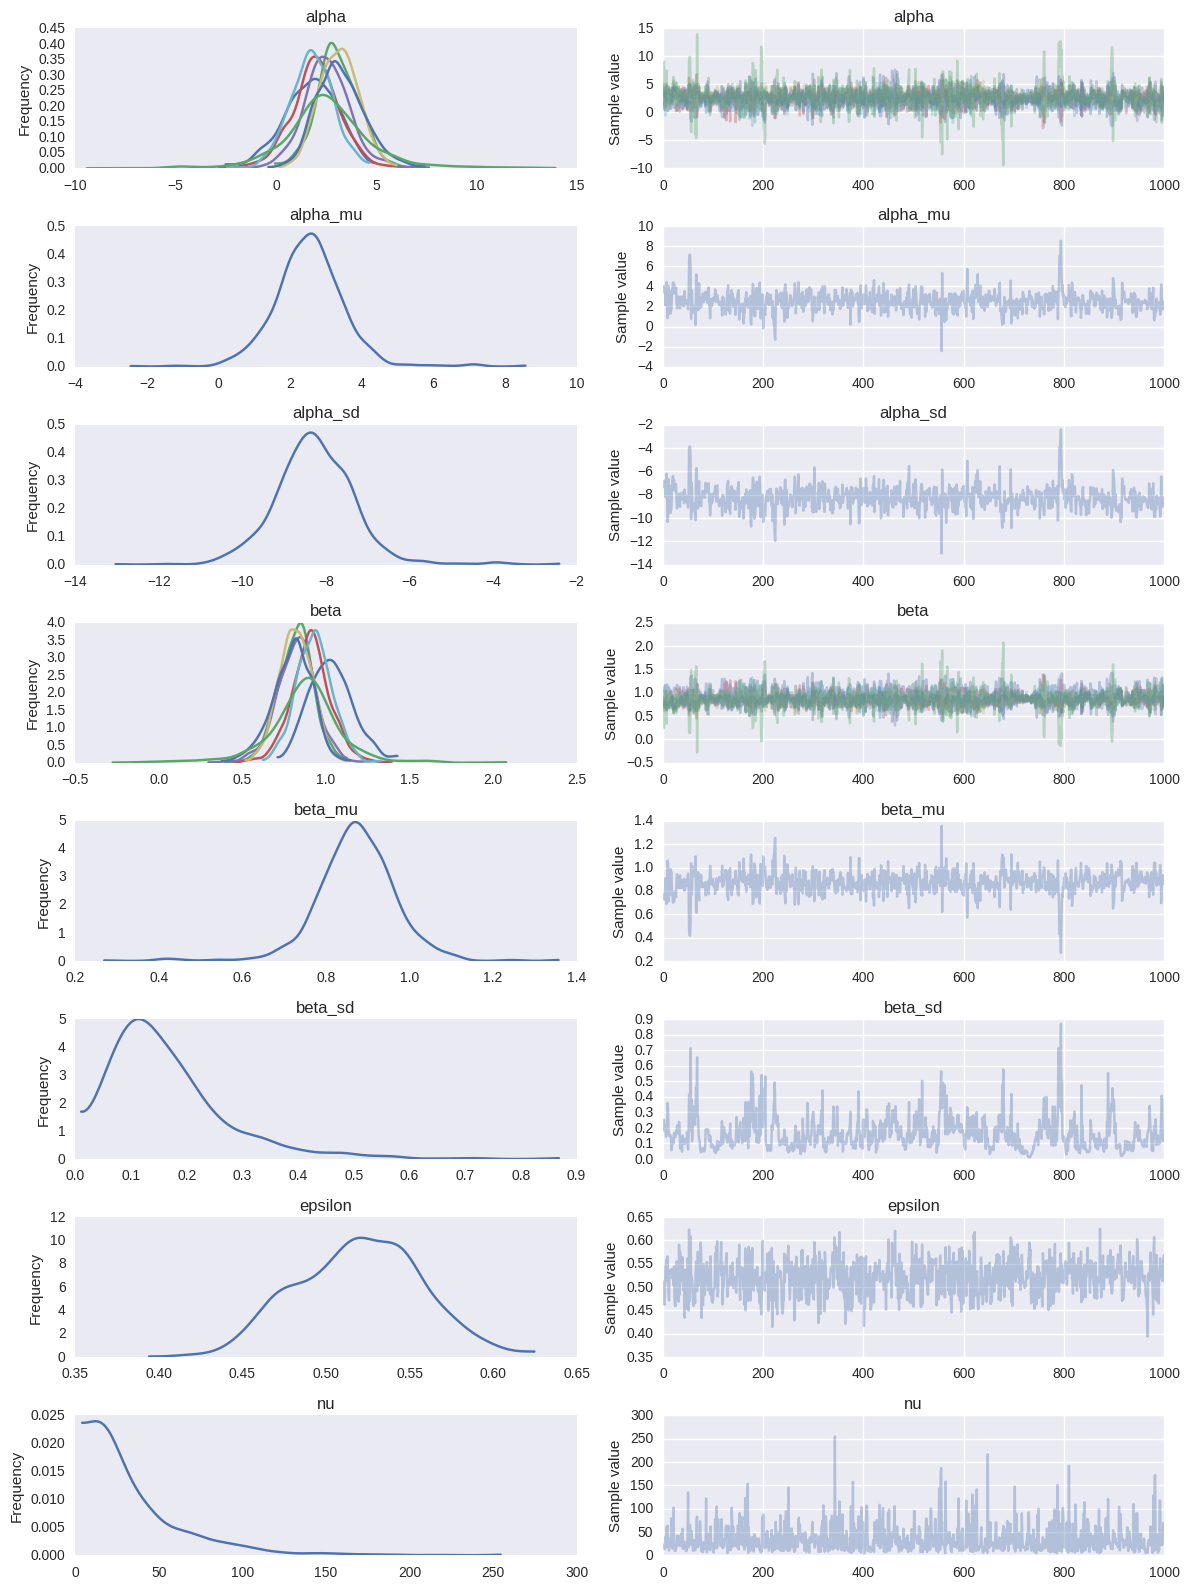

In [28]:
varnames=['alpha', 'alpha_mu','alpha_sd', 'beta', 'beta_mu', 'beta_sd', 'epsilon', 'nu']
pm.traceplot(trace_hm, varnames);